In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Add, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

# Separazione di immagini

Questo progetto ha l'obiettivo di separare un'immagine, ottenuta come somma di due immagini, nelle sue componenti originali.

Le due immagini di origine, img1 e img2, provengono da dataset diversi: MNIST e Fashion-MNIST, rispettivamente.

Non è consentita alcuna pre-elaborazione. La rete neurale riceve in input l'immagine combinata (img1 + img2) e restituisce le predizioni (hat_img1 e hat_img2).

Le prestazioni vengono valutate utilizzando l'errore quadratico medio (MSE) tra le immagini predette e quelle di riferimento.

Entrambi i dataset (MNIST e Fashion-MNIST) sono in scala di grigi. Per semplicità, tutti i campioni vengono adattati alla risoluzione (32,32).

In [15]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

(60000, 28, 28)
(60000, 32, 32)


In [16]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Qui di seguito un semplcie generatore dei dati.

In [17]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Definiamo un generatore con batchsize=1 e visualizziamo qualche dato.

In [18]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

In [19]:
def show_images(x,y1,y2, title=""):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    if title:
        fig.suptitle(title, fontsize=14, y=1.05)
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

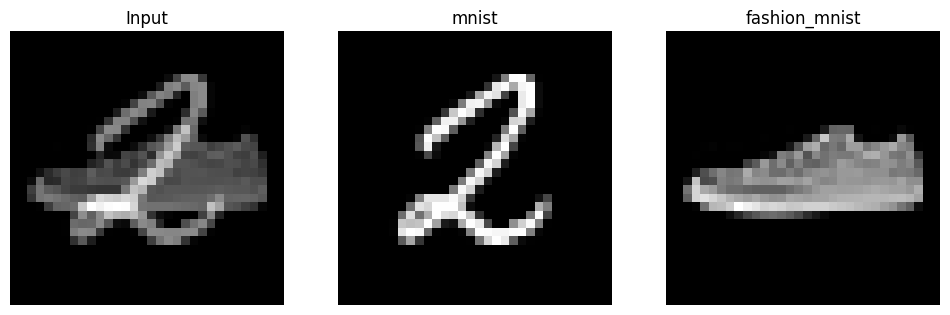

In [20]:
x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])

# Valutazione delle prestazioni

Definiano un generatore di test con batchsize 5000.

In [21]:
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,5000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

Testiamo un semplice modelli che predice due volte l'immagine presa in input.
Voi dovrete rimpiazzare questo modello che la rete che avrete allenato.

In [22]:
def ide_model(x):
   return x,x

# La mia rete neurale

Questo modello si basa su un'architettura encoder-decoder, tipica delle UNet, con la differenza che qui è presente un encoder condiviso che estrae le feature comuni e due decoder indipendenti creati "ad hoc" ciascuno sul proprio dataset.

## Struttura

- Encoder Condiviso
  - Composto da una serie di layer convoluzionali, seguiti da operazioni di MaxPooling2D che riducono progressivamente la dimensione spaziale e facilitano l'estrazione delle feature.

- Decoder MNIST
  - Architettura semplice e lineare.
  - Utilizza layer convoluzionali seguiti da operazioni di UpSampling2D e concatenazione delle skip connection, garantendo così la preservazione dei dettagli spaziali e prevenendo l'output completamente nero.

- Decoder Fashion-MNIST
  - Design più articolato che, oltre alla struttura del decoder MNIST, integra blocchi residuali per gestire pattern più complessi, presenti in questo dataset.
  - Viene attribuito un peso maggiore (1.2) nella funzione di loss per migliorare le performance sul dataset Fashion-MNIST.

## Evoluzione della Rete

Il modello ha subito diverse iterazioni chiave:

### Prima Versione (mse $ \approx $ 0.005)
- UNet con architettura base con un encoder e due decoder simmetrici.
- Performance limitate su Fashion-MNIST.

### Seconda Versione (mse $ \approx $ 0.001)
- Introduzione di due decoder distinti:
  - Decoder MNIST: architettura lineare ottimizzata.
  - Decoder Fashion-MNIST: design più complesso con blocchi residuali.

### Terza Versione (mse $ \approx $ 0.0008)
- Introduzione del learning rate dinamico tramite ReduceLROnPlateau.
- Early stopping per prevenire l'overfitting.
- Utilizzo di loss weights differenziate, migliorando ulteriormente Fashion-MNIST.

### Versione Attuale, (mse = 0.00039955846)
- Ottimizzazione del learning rate iniziale.
- Regolazione accurata del factor e del patience del callback ReduceLROnPlateau.
- Fine tuning del numero di filtri nei vari layer per determinare la struttura finale.

# Training
Il training è avvenuto sulla piattaforma Google Colab e è durato circa 3 ore con il runtime L4. Nei test precedenti non era successo, ma in questa esecuzione all'epoca 67 è scattato l'early stopping che non ha permesso di concludere le 100 epoche preimpostate; nonostante questo l'accuratezza finale è risultata abbastanza simile a quella delle esecuzioni precedenti.

In [23]:
def create_conv_block(x, filters, kernel_size):
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def create_residual_block(x, filters):
    residual = x
    x = create_conv_block(x, filters, (3, 3))
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])
    return Activation('relu')(x)

def create_encoder(input_layer):
    x = Reshape((32, 32, 1))(input_layer)
    x = create_conv_block(x, filters=64, kernel_size=(5, 5))
    skip1 = x
    x = MaxPooling2D((2, 2))(x)
    x = create_conv_block(x, filters=128, kernel_size=(3, 3))
    skip2 = x
    x = MaxPooling2D((2, 2))(x)
    x = create_conv_block(x, filters=256, kernel_size=(3, 3))
    x = create_conv_block(x, filters=256, kernel_size=(3, 3))
    return x, skip1, skip2

def create_mnist_decoder(x, skip1, skip2):
    x = create_conv_block(x, filters=128, kernel_size=(3, 3))
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip2])
    x = create_conv_block(x, filters=128, kernel_size=(3, 3))
    x = create_conv_block(x, filters=64, kernel_size=(3, 3))
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip1])
    x = create_conv_block(x, filters=64, kernel_size=(3, 3))
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return Reshape((32, 32))(x)

def create_fashion_mnist_decoder(x, skip1, skip2):
    x = create_conv_block(x, filters=192, kernel_size=(3, 3))
    x = create_residual_block(x, filters=192)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip2])
    x = create_conv_block(x, filters=128, kernel_size=(3, 3))
    x = create_residual_block(x, filters=128)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip1])
    x = create_conv_block(x, filters=64, kernel_size=(3, 3))
    x = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)
    return Reshape((32, 32))(x)

def create_my_unet():
    input_img = Input(shape=(32, 32))
    x, skip1, skip2 = create_encoder(input_img)
    output1 = create_mnist_decoder(x, skip1, skip2)
    output2 = create_fashion_mnist_decoder(x, skip1, skip2)
    model = Model(inputs=input_img, outputs=[output1, output2])
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=['mse', 'mse'],
        loss_weights=[1.0, 1.2]
    )
    return model

traingen = datagenerator(mnist_x_train, fashion_mnist_x_train, 32)
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

model = create_my_unet()
model.summary()
history = model.fit(
    traingen,
    steps_per_epoch=10000,
    epochs=100,
    validation_data=testgen,
    validation_steps=50,
    callbacks=callbacks,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 32, 32, 1)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 32, 32, 64)     │          1,664 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 32, 32, 64)     │            256 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ activation_15[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 16, 16, 128)    │            512 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 16, 16, 128)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ activation_16[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 8, 8, 256)      │          1,024 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 8, 8, 256)      │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 8, 8, 256)      │        590,080 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 8, 8, 256)      │          1,024 │ conv2d_20[0][0]        │
│ (BatchNormalization) 

 Total params: 3,590,146 (13.70 MB)

 Trainable params: 3,585,922 (13.68 MB)

 Non-trainable params: 4,224 (16.50 KB)

Epoch 1/100
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 197s 18ms/step - loss: 0.0066 - reshape_4_loss: 0.0028 - reshape_5_loss: 0.0032 - val_loss: 0.0021 - val_reshape_4_loss: 8.9856e-04 - val_reshape_5_loss: 0.0010 - learning_rate: 0.0010
Epoch 2/100
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 177s 18ms/step - loss: 0.0020 - reshape_4_loss: 8.4366e-04 - reshape_5_loss: 9.7460e-04 - val_loss: 0.0016 - val_reshape_4_loss: 7.0850e-04 - val_reshape_5_loss: 7.5237e-04 - learning_rate: 0.0010
Epoch 3/100
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 176s 18ms/step - loss: 0.0016 - reshape_4_loss: 6.9419e-04 - reshape_5_loss: 7.6459e-04 - val_loss: 0.0014 - val_reshape_4_loss: 6.3538e-04 - val_reshape_5_loss: 6.7507e-04 - learning_rate: 0.0010
Epoch 4/100
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 176s 18ms/step - loss: 0.0014 - reshape_4_loss: 6.2428e-04 - reshape_5_loss: 6.6662e-04 - val_loss: 0.0014 - val_reshape_4_loss: 6.1814e-04 - val_reshape_5_loss: 6.1293e-04 - learning_rate: 0.0010
Epoch 5/100
10000/10000 ━━━━━━━━━━━━━━━━━━━━

In [24]:
def eval_model(model):
    x, (y1, y2) = next(testgen)
    pred1, pred2 = model.predict(x)
    return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2)) / 2

In [33]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [40]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mse =  0.0003995584609960019
standard deviation =  3.394178844460743e-06


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


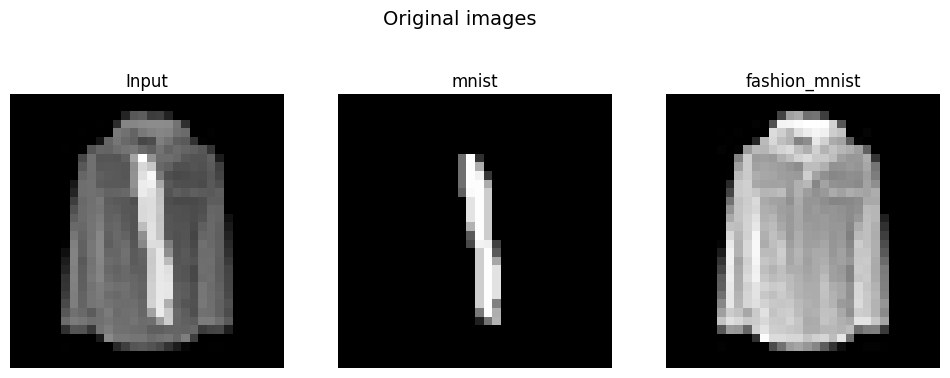

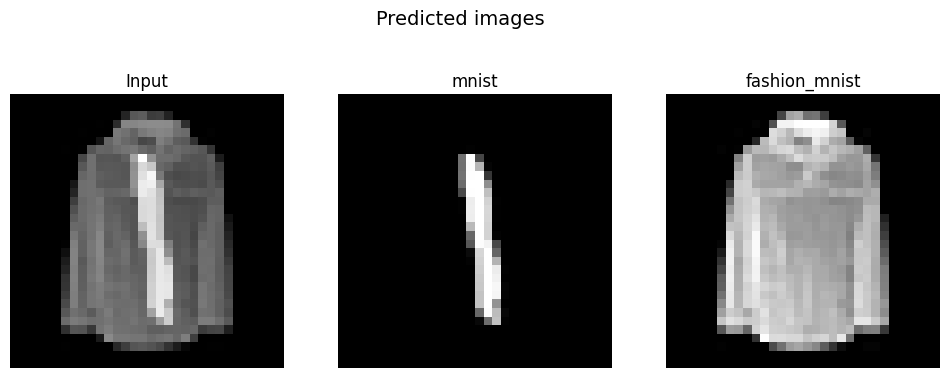

In [41]:
x, (y1, y2) = next(testgen)
pred1, pred2 = model.predict(x)
show_images(x[0], y1[0], y2[0], "Original images")
show_images(x[0], pred1[0], pred2[0], "Predicted images")

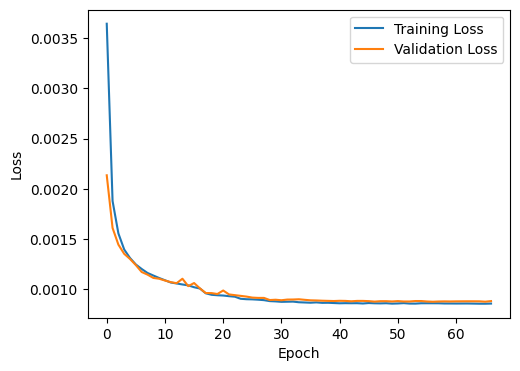

In [42]:
plot_training_history(history)

# Cosa consegnare

Come di consueto, dovrete consegnare un unico notebook eseguibile su Colab. Il notebook dovrà essere adeguatamente commentato, contenere l'intero tracciato dell'addestramento, il calcolo dell'MSE nel formato specificato sopra e alcuni esempi.

Buon lavoro!